# Методы улучшения контраста изображений

- Линейное масштабирование яркости
- Гамма-коррекция
- Выравнивание гистограмм
- Адаптивное выравнивание гистограмм и CLAHE
- Histogram matching

In [143]:
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow # for image display
from IPython.display import display

from skimage import io
from PIL import Image
import matplotlib.pylab as plt

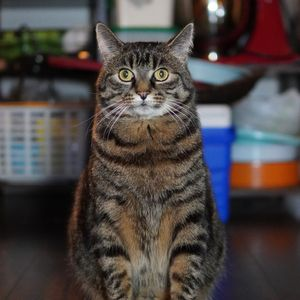

In [144]:
url = "https://placecats.com/300/300"
myImg = io.imread(url)  # RGB

display(Image.fromarray(myImg[:,:,]))

image = myImg

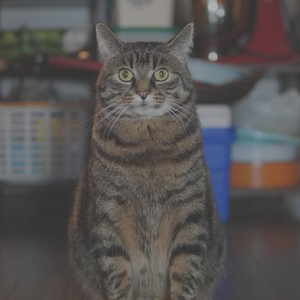

In [145]:
mod_image = image // 2 + 50

display(Image.fromarray(mod_image))


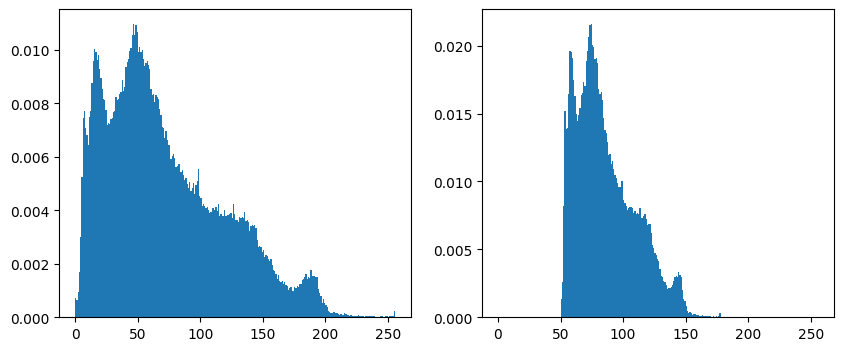

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(image.ravel(), bins = 256, range = [0,256], density=True )
axs[1].hist(mod_image.ravel(), bins = 256, range = [0,256], density=True)

plt.show()

In [147]:
print(image.min(), image.max(), image.mean(), image.ptp())
print(mod_image.min(), mod_image.max(), mod_image.mean(), mod_image.ptp())      # ptp = peak to peak 

0 255 71.53171851851852 255
50 177 85.51641851851852 127


Контраст Глобальный

$ \Huge { C_g = \frac{a_{max} - a_{min}}{P - 1 } = \frac{a_{max} - a_{min}}{P_{max} + P_{min} } } $


Масштабирование яркости

$ \Huge { \tilde a (m,n) = g(a(m,n)) } $

$ g $ - передаточная функция преобразования

$ \Huge { g (a) = \frac{a - a_{min}}{a_{max} - a_{min} } (P_{max} - P_{min}) + P_{min} } $



255.0 0.0 float64


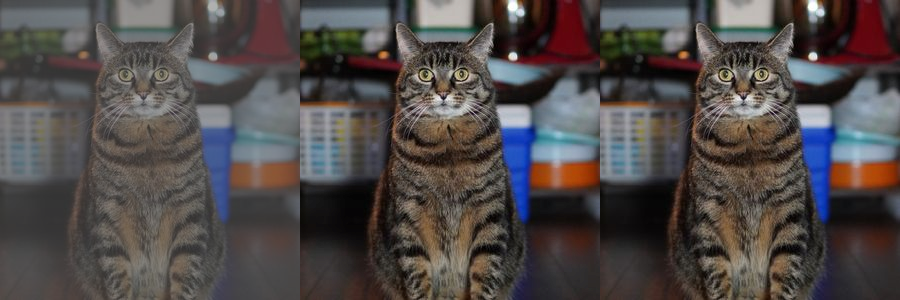

In [148]:
g = (mod_image - mod_image.min()) * 255.0  / float(mod_image.ptp()) + 0

print(g.max(), g.min(), g.dtype)

conc = cv2.hconcat((mod_image, g.astype(np.uint8), image))

display(Image.fromarray(conc))



Отображение части динамического диапазона 

$ 
\Huge {
g(a) =
 \begin{cases}
   0, a<w_{min} 
   \\
   \frac{a - w_{min}}{w_{max} - w_{min} } (P - 1), w_{min} <= a <= w_{max}
   \\
   P-1, a > w_{max}
 \end{cases}
}
$


In [159]:
wmin = 20
wmax = 200

i1 = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
i1 = image

i2 = np.where(i1<wmin, 0, i1)
i3 = np.where(i2>wmax, 255, i2)
i4 = np.where((i3 >= wmin) & (i3 <= wmax), ((i3-wmin) / float(wmax - wmin) * 255.0).astype(np.uint8), i3)

In [160]:
i4.max(), i4.min(), i4.shape

(255, 0, (300, 300, 3))

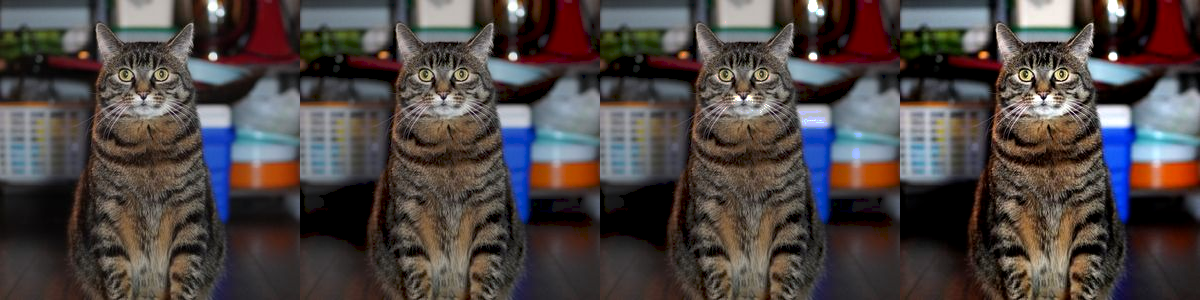

In [161]:
conc = cv2.hconcat((i1, i2, i3, i4))
display(Image.fromarray(conc))

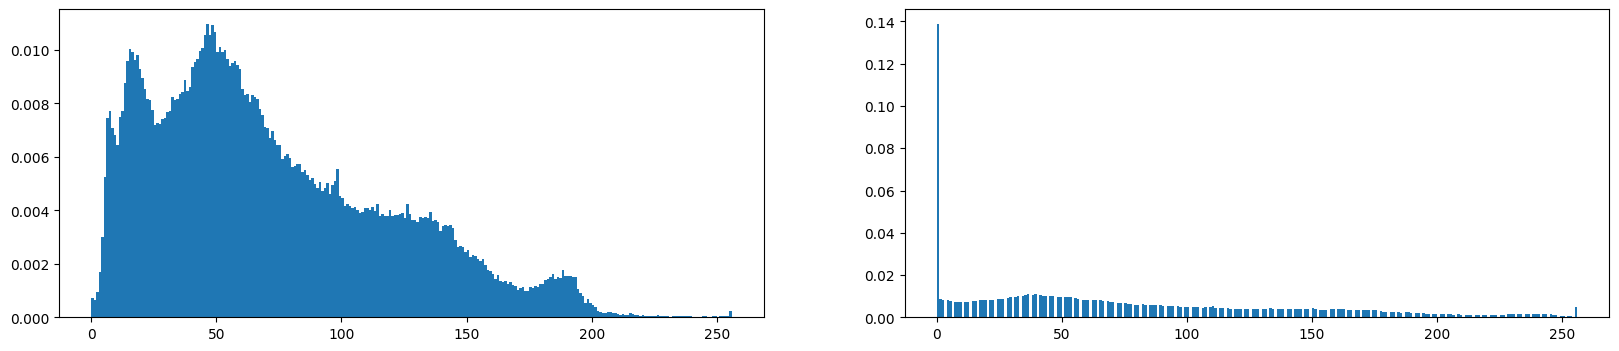

In [163]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
axs[0].hist(i1.ravel(), bins = 256, range = [0,256], density=True)
axs[1].hist(i4.ravel(), bins = 256, range = [0,256], density=True)

plt.show()

Нелинейное отображение, гамма-коррекция изображения

$ \Huge { g(a) = \left( \frac{a - a_{min}}{ a_{max} - a_{min} } \right) ^ \gamma (P-1) } $



In [169]:
gamma = 0.5
gg = ( ((image - image.min()) / (image.ptp()))**gamma * 255.0 ).astype(np.uint8)
## иногда 1/gamma

![gamma](<Screenshot from 2023-10-17 20-50-49.png>)

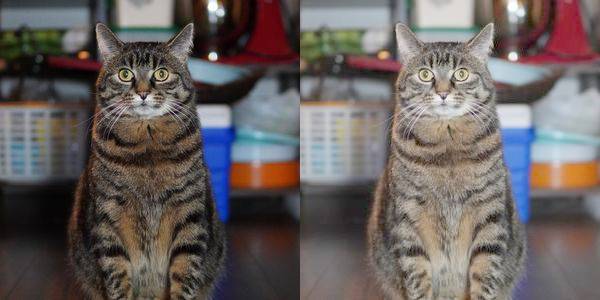

In [170]:
conc = cv2.hconcat((image, gg))
display(Image.fromarray(conc))

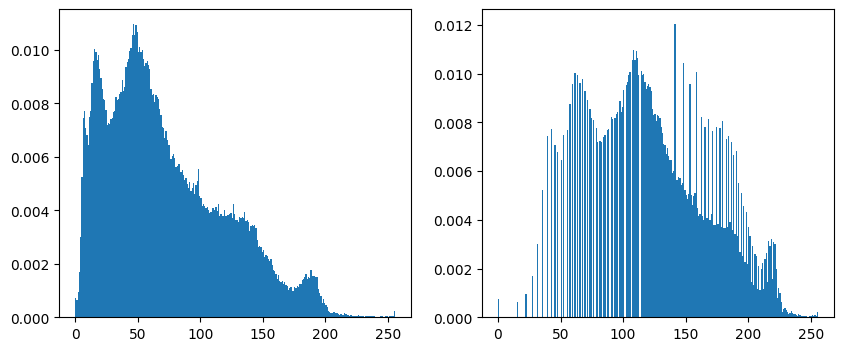

In [171]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(image.ravel(), bins = 256, range = [0,256], density=True )
axs[1].hist(gg.ravel(), bins = 256, range = [0,256], density=True)

plt.show()

# Выравнивание гистограммы

Нормализованная гистограмма яркости

Оценка функции распределения яркостей изображения –
эмпирическая функция распределения


In [181]:
url = "https://placecats.com/320/320"
image = io.imread(url) 

In [182]:
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

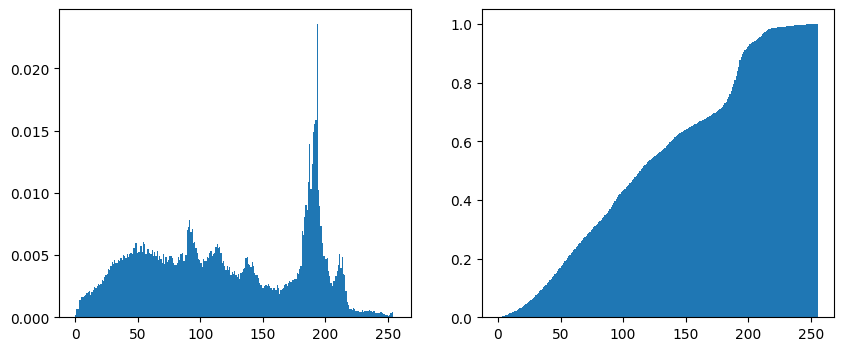

In [183]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4),)
axs[0].hist(gray_image.ravel(), bins = 256, range = [0,256], density=True )                 # PDF
axs[1].hist(gray_image.ravel(), bins = 256, range = [0,256], density=True, cumulative=True) # CDF

plt.show()

In [184]:
# %%time
eq_image = cv2.equalizeHist(gray_image)

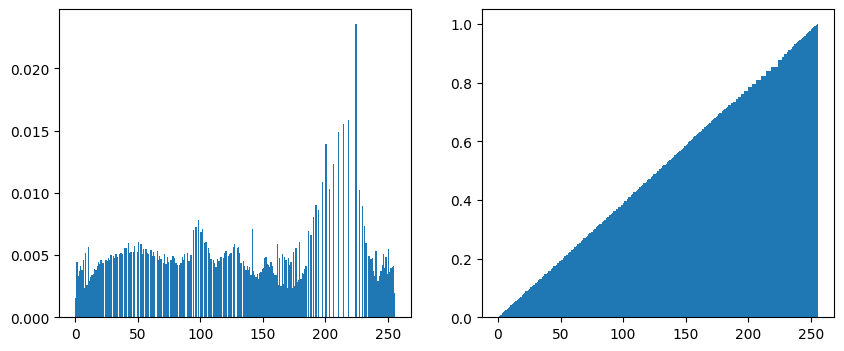

In [185]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4),)
axs[0].hist(eq_image.ravel(), bins = 256, range = [0,256], density=True )
axs[1].hist(eq_image.ravel(), bins = 256, range = [0,256], density=True, cumulative=True)

plt.show()

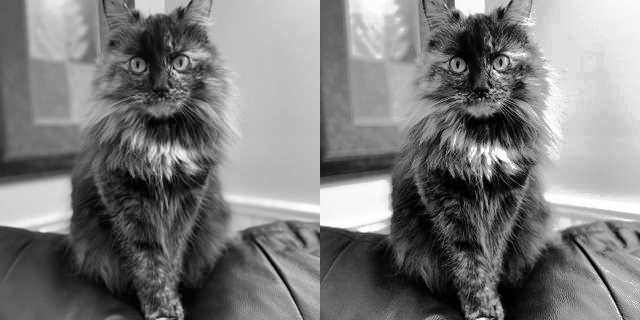

In [186]:
conc = cv2.hconcat((gray_image, eq_image))
display(Image.fromarray(conc))

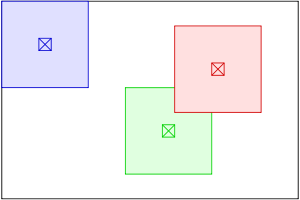

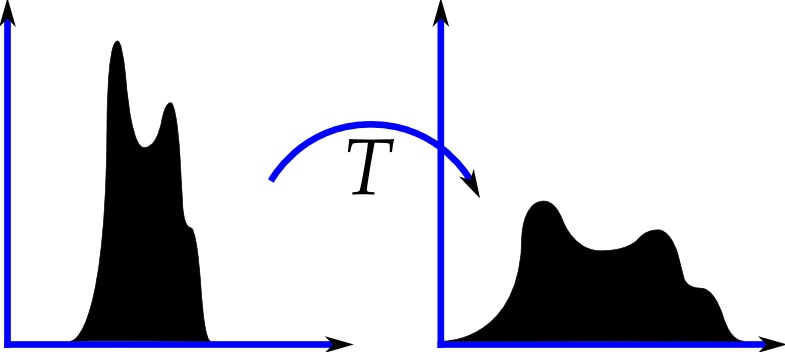

При выравнивании гистограммы предполагается, что яркости всех пикселей одинаково важны и не учитывает никакой информации об объектах на изображении

Недостаток: большая и темная фоновая область может оказаться излишне контрастированной за счет уменьшения контраста объекта на переднем плане

Центральному пикселю окна присваивается яркость, выровненная по локальной гистограмме (local histogram equalization, LHE)
https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_local_equalize.html

Алгоритм AHE (Adaptive histogram equalization):
1) Разбиение изображения на черепичные фрагменты
2) Расчет локальной гистограммы в каждом черепичном фрагменте
3) Выравнивание яркостей в каждом фрагменте
4) Билинейная интерполяция яркостей (для устранения “швов” на границах фрагментов)

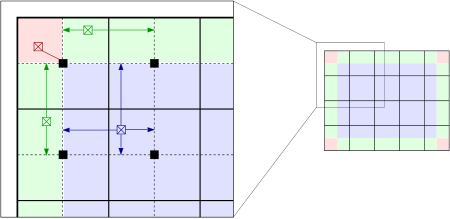

In [187]:
url = "https://placecats.com/300/300"
image = io.imread(url) 
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [188]:
gray_image.shape

(300, 300)

In [190]:
tiles = []
eq_tiles = []
h, w = gray_image.shape
ht = h // 2 
wt = w // 2

for i in range(2):
    for j in range(2):
        tile = gray_image[i*ht:i*ht+ht, j*wt:j*wt+wt]
        tiles.append(tile)

for tile in tiles:
    eq_tile = cv2.equalizeHist(tile)
    eq_tiles.append(eq_tile)

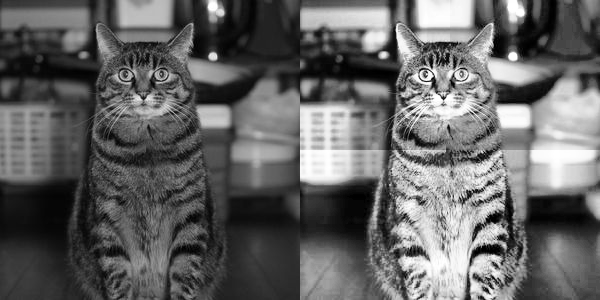

In [191]:
conc1 = cv2.hconcat((tiles[0], tiles[1]))
conc2 = cv2.hconcat((tiles[2], tiles[3])) 
concf = cv2.vconcat((conc1, conc2))

eq_conc1 = cv2.hconcat((eq_tiles[0], eq_tiles[1]))
eq_conc2 = cv2.hconcat((eq_tiles[2], eq_tiles[3])) 
eq_concf = cv2.vconcat((eq_conc1, eq_conc2))

concall = cv2.hconcat((concf, eq_concf))

display(Image.fromarray(concall))

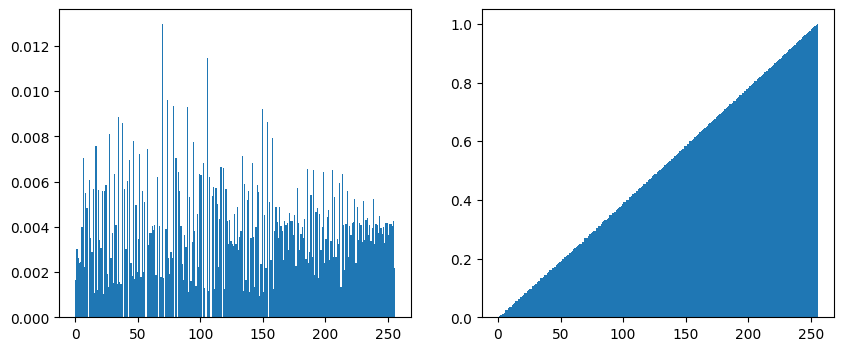

In [192]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4),)
axs[0].hist(eq_concf.ravel(), bins = 256, range = [0,256], density=True )
axs[1].hist(eq_concf.ravel(), bins = 256, range = [0,256], density=True, cumulative=True)

plt.show()

# CLAHE (Contrast Limited Adaptive Histogram Equalization)


![Alt text](image-1.png)

In [138]:
# gray_image2 = gray_image.copy() // 2 + 50

In [202]:
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(6, 6))
cl1 = clahe.apply(gray_image)


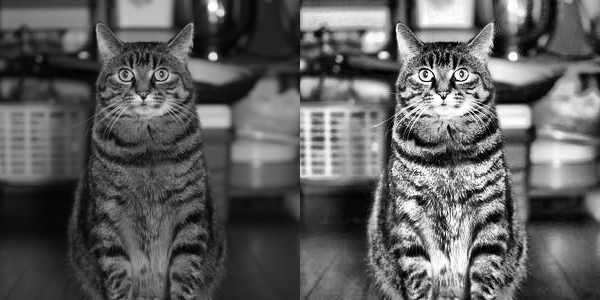

In [203]:
conc = cv2.hconcat((gray_image, cl1))
display(Image.fromarray(conc))

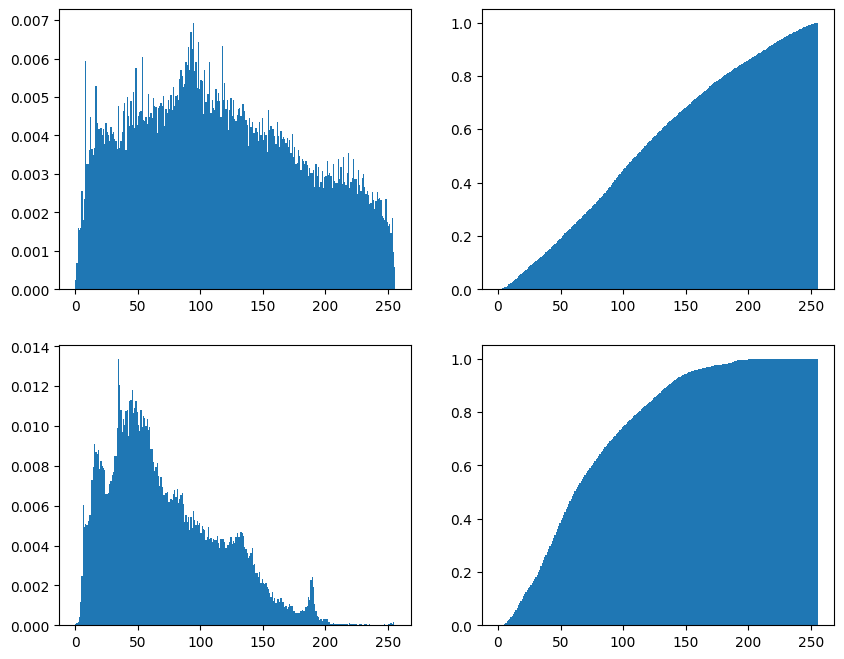

In [204]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0,0].hist(cl1.ravel(), bins = 256, range = [0,256], density=True )
axs[0,1].hist(cl1.ravel(), bins = 256, range = [0,256], density=True, cumulative=True)
axs[1,0].hist(gray_image.ravel(), bins = 256, range = [0,256], density=True )
axs[1,1].hist(gray_image.ravel(), bins = 256, range = [0,256], density=True, cumulative=True)

plt.show()

# Histogram matching 

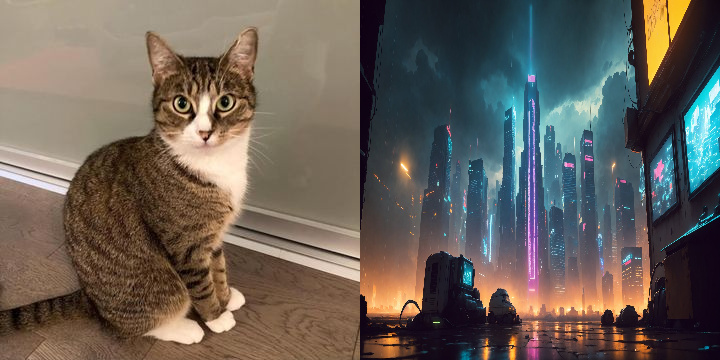

In [220]:
url = "https://placecats.com/360/360"
image = io.imread(url) 
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


image_ref = io.imread("./111.jpg")
image_ref = cv2.resize(image_ref, (360, 360))

conc = cv2.hconcat((image, image_ref))
display(Image.fromarray(conc))

In [221]:
from skimage import exposure

matched = exposure.match_histograms(image, image_ref, channel_axis=-1)


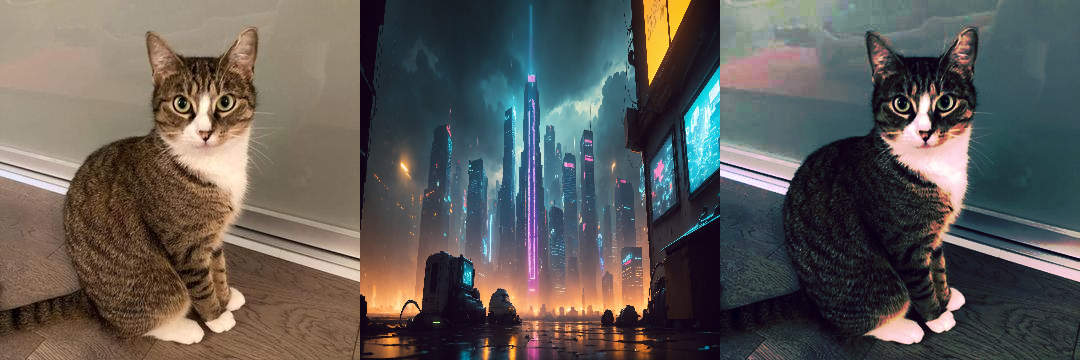

In [222]:
conc = cv2.hconcat((image, image_ref, matched))
display(Image.fromarray(conc))

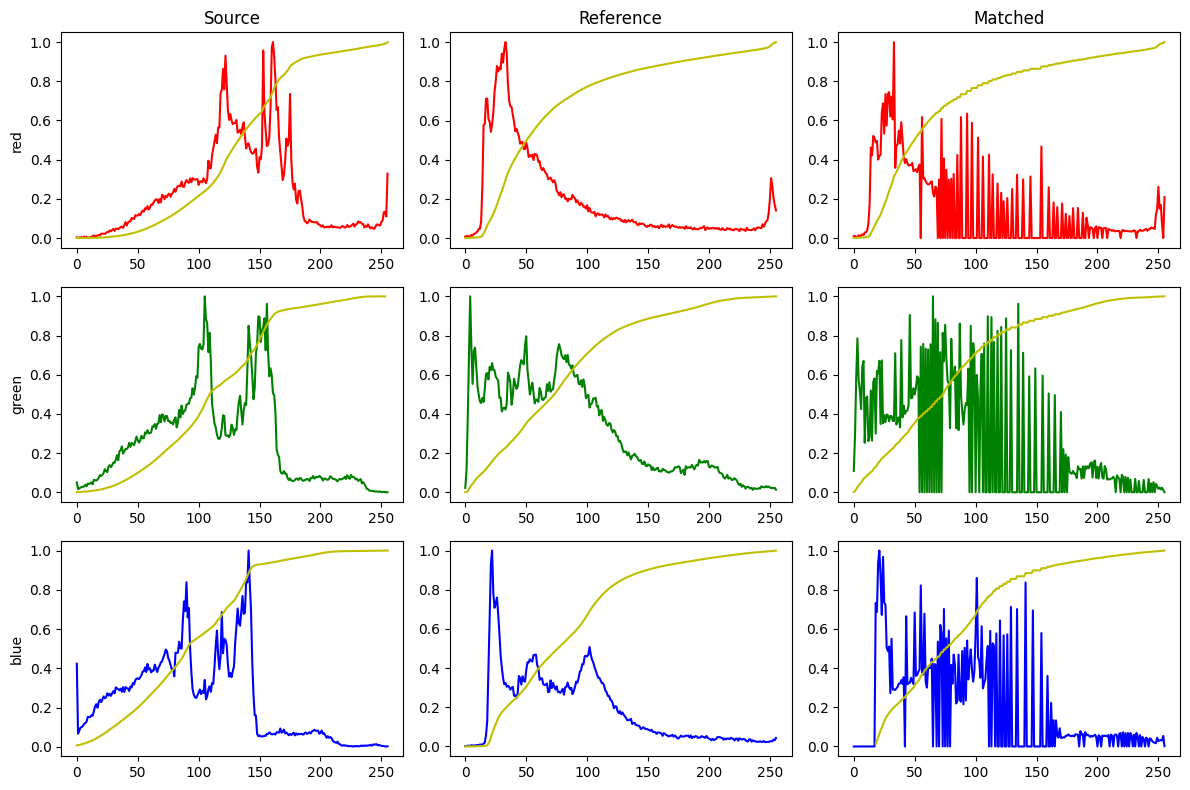

In [223]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))

for i, img in enumerate((image, image_ref, matched)):
    for c, c_color in enumerate(('red', 'green', 'blue')):
        img_hist, bins = exposure.histogram(img[..., c], source_range='dtype')
        axes[c, i].plot(bins, img_hist / img_hist.max(), c_color)
        img_cdf, bins = exposure.cumulative_distribution(img[..., c])
        axes[c, i].plot(bins, img_cdf, "y")
        axes[c, 0].set_ylabel(c_color)

axes[0, 0].set_title('Source')
axes[0, 1].set_title('Reference')
axes[0, 2].set_title('Matched')

plt.tight_layout()
plt.show()